In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'impala'," "'monetdb'," "'mssql'," "'mysql',"
 "'oracle'," "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (19947, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', MultinomialNB 1 1
MODEL_DATASETS_MISSING 'db2', NuSVC 18 9
MODEL_DATASETS_MISSING 'db2', NuSVC_pipe 18 9
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 4 4
MODEL_DATASETS_MISSING 'db2', RANSACRegressor_pipe 4 4
MODEL_DATASETS_MISSING 'firebird', MultinomialNB 1 0
MODEL_DATASETS_MISSING 'impala', LGBMClassifier 18 12
MODEL_DATASETS_MISSING 'impala', LGBMClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'impala', LinearDiscriminantAnalysis 18 12
MODEL_DATASETS_MISSING 'impala', LinearDiscriminantAnalysis_pipe 18 12
MODEL_DATASETS_MISSING 'impala', LogisticRegression 18 14
MODEL_DATASETS_MISSING 'impala', LogisticRegressionCV 18 12
MODEL_DATASETS_MISSING 'impala', LogisticRegressionCV_pipe

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,CalibratedClassifierCV_pipe,"'p_DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.calibration
1,MultinomialNB,"'DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
2,NuSVC,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.svm
3,NuSVC,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.svm
4,NuSVC,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.svm


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(20370, 8)

In [19]:
df.est_dialect.value_counts()

'impala',      2037
'mysql',       2037
'oracle',      2037
'pgsql',       2037
'mssql',       2037
'teradata',    2037
'monetdb',     2037
'firebird',    2037
'db2',         2037
'sqltm',       2037
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'impala',   'AssertionError:'),                                           293
            TIMEOUT                                                       200
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                     134
'db2',      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mssql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'monetdb',  "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mysql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'oracle',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'impala',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'pgsql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'firebird', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'sqltm',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'teradata', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   75
'firebird', "DatabaseError:('Error                                         70
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   62
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   57
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   55
'teradata', TIMEOUT                                                        52
'oracle',   TIMEOUT                                                        48
'impala',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   44
'monetdb',  TIMEOUT                                                        43
            ) inputs not the same size                                     42
'db2',      TIMEOUT                                                        34
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   32
'teradata', 'DatabaseError:(teradata.api.DatabaseError)                    14
'impala',   "DBAPIError:(impala.error.HiveServer2Error)                    13
'monetdb',  ) Illegal argumen                                              12
'firebird', TIMEOUT                                                        10
'sqltm',    TIMEOUT                                                         9
'pgsql',    TIMEOUT                                                         9
'mysql',    TIMEOUT                                                         9
'mssql',    TIMEOUT                                                         9
'monetdb',  ) GDK reported error: GDKload: cannot open: nam...              8
'sqltm',    ) too many columns in result se                                 6
'db2',      : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
'sqltm',    ) too many terms in compound SELEC                              6
'teradata', "DatabaseError:(teradata.api.DatabaseError)                     6
'pgsql',    ) target lists can have at most 1664 entrie                     6
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                       3
'impala',   "StatementError:(thriftpy.protocol.exc.TProtoco...              3
'pgsql',    ) stack depth limit exceededHINT:  Increase the...              2
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'mssql',    8631, b'Internal error: Server stack limit has ...              2
'monetdb

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,17841
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",900
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",569
TIMEOUT,423
"'AssertionError:'),",293
'DatabaseError:(fdb.fbcore.DatabaseError),134
"""DatabaseError:('Error",70
) inputs not the same size,42
'DatabaseError:(teradata.api.DatabaseError),14
"""DBAPIError:(impala.error.HiveServer2Error)",13


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

DummyClassifier            176
DummyClassifier_pipe       161
IsolationForest             54
IsolationForest_pipe        53
NuSVC_pipe                  36
OneVsRestClassifier         29
FastICA                     26
FactorAnalysis              17
Lars                         9
AdaBoostClassifier_pipe      3
AdaBoostClassifier           3
EllipticEnvelope             2
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

LatentDirichletAllocation    180
NMF                          180
SparsePCA                    180
MiniBatchSparsePCA           180
KernelPCA                    180
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,16,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,45,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_200_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_200_22_0_1__2_3_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_200_22_0_1__8_9_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,16,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_200_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,45,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_200_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,45,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                      \
dialect                         db2 firebird impala monetdb mssql mysql   
model_category                                                            
lightgbm.sklearn                 48       48     48      48    48    48   
sklearn.calibration              36       36     36      36    36    36   
sklearn.covariance               12       12     12      12    12    12   
sklearn.decomposition            90       90     90      90    90    90   
sklearn.discriminant_analysis    36       36     36      36    36    36   
sklearn.ensemble                252      252    252     252   252   252   
sklearn.feature_selection       162      162    162     162   162   162   
sklearn.kernel_ridge             12       12     12      12    12    12   
sklearn.linear_model            488      488    488     488   488   488   
sklearn.multiclass               72       72     72      72    72    72   
sklearn.naive_bayes              73       73     73      73    73    73   
sklearn.neural_network           48       48     48      48    48    48   
sklearn.pipeline                 54       54     54      54    54    54   
sklearn.preprocessing           216      216    216     216   216   216   
sklearn.svm                     156      156    156     156   156   156   
sklearn.tree                     96       96     96      96    96    96   
xgboost.sklearn                  48       48     48      48    48    48   
All                            1899     1899   1899    1899  1899  1899   

                                                                  
dialect                       oracle pgsql sqltm teradata    All  
model_category                                                    
lightgbm.sklearn                  48    48    48       48    480  
sklearn.calibration               36    36    36       36    360  
sklearn.covariance                12    12    12       12    120  
sklearn.decomposition             90    90    90       90    900  
sklearn.discriminant_analysis     36    36    36       36    360  
sklearn.ensemble                 252   252   252      252   2520  
sklearn.feature_selection        162   162   162      162   1620  
sklearn.kernel_ridge              12    12    12       12    120  
sklearn.linear_model             488   488   488      488   4880  
sklearn.multiclass                72    72    72       72    720  
sklearn.naive_bayes               73    73    73       73    730  
sklearn.neural_network            48    48    48       48    480  
sklearn.pipeline                  54    54    54       54    540  
sklearn.preprocessing            216   216   216      216   2160  
sklearn.svm                      156   156   156      156   1560  
sklearn.tree                      96    96    96       96    960  
xgboost.sklearn                   48    48    48       48    480  
All                             1899  1899  1899     1899  18990

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird    impala   monetdb   
model_category                                                          
lightgbm.sklearn               0.000000  0.083333  0.541667  0.041667   
sklearn.calibration            0.027778  0.000000  0.444444  0.055556   
sklearn.covariance             0.166667  0.166667  0.166667  0.250000   
sklearn.decomposition          0.033333  0.100000  0.244444  0.277778   
sklearn.discriminant_analysis  0.000000  0.333333  0.666667  0.055556   
sklearn.ensemble               0.047619  0.226190  0.273810  0.087302   
sklearn.feature_selection      0.000000  0.000000  0.222222  0.049383   
sklearn.kernel_ridge           0.000000  0.583333  0.000000  0.000000   
sklearn.linear_model           0.018443  0.002049  0.198770  0.030738   
sklearn.multiclass             0.041667  0.041667  0.416667  0.097222   
sklearn.naive_bayes            0.013699  0.082192  0.260274  0.054795   
sklearn.neural_network         0.000000  0.000000  0.395833  0.041667   
sklearn.pipeline               0.000000  0.240741  0.222222  0.055556   
sklearn.preprocessing          0.055556  0.083333  0.222222  0.087963   
sklearn.svm                    0.115385  0.256410  0.365385  0.185897   
sklearn.tree                   0.000000  0.385417  0.177083  0.031250   
xgboost.sklearn                0.000000  0.000000  0.479167  0.041667   
All                            0.032122  0.110058  0.272249  0.077936   

                                                                       \
dialect                           mssql     mysql    oracle     pgsql   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.166667  0.083333  0.166667   
sklearn.decomposition          0.033333  0.033333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.047619  0.047619  0.047619  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.018443  0.018443  0.020492  0.018443   
sklearn.multiclass             0.041667  0.041667  0.041667  0.041667   
sklearn.naive_bayes            0.013699  0.013699  0.013699  0.013699   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.000000  0.027778   
sklearn.svm                    0.038462  0.038462  0.288462  0.038462   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.000000  0.000000  0.000000  0.000000   
All                            0.018957  0.018957  0.039494  0.022117   

                                                             
dialect                           sqltm  teradata       All  
model_category                                               
lightgbm.sklearn               0.000000  0.062500  0.072917  
sklearn.calibration            0.000000  0.000000  0.052778  
sklearn.covariance             0.166667  0.166667  0.166667  
sklearn.decomposition          0.033333  0.033333  0.085556  
sklearn.discriminant_analysis  0.000000  0.000000  0.105556  
sklearn.ensemble               0.047619  0.071429  0.094444  
sklearn.feature_selection      0.000000  0.000000  0.027160  
sklearn.kernel_ridge           0.000000  0.000000  0.058333  
sklearn.linear_model           0.018443  0.014344  0.035861  
sklearn.multiclass             0.041667  0.069444  0.087500  
sklearn.naive_bayes            0.013699  0.164384  0.064384  
sklearn.neural_network         0.000000  0.000000  0.043750  
sklearn.pipeline               0.0000

In [38]:
df.to_csv('report_extensive_tests.csv')

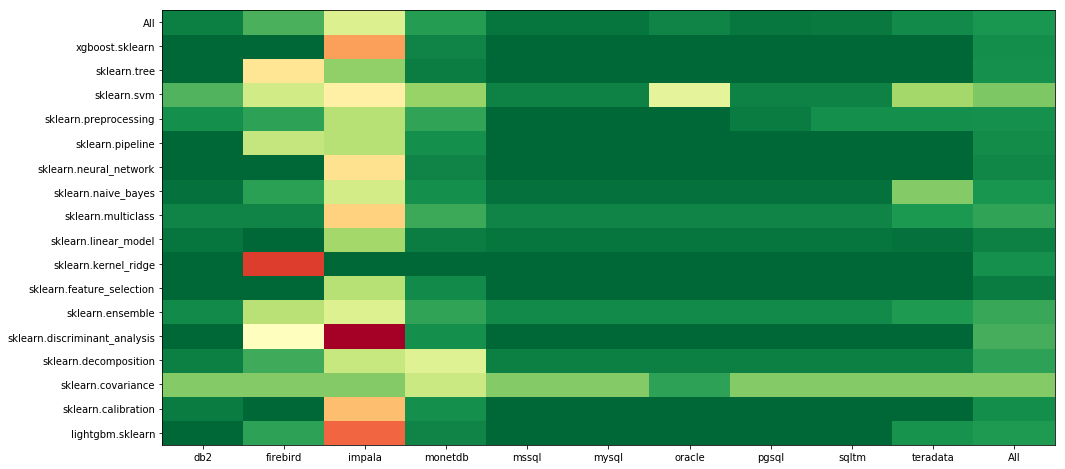

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'firebird', SUCCESS                                                 44
            'DatabaseError:(fdb.fbcore.DatabaseError)                4
'impala',   TIMEOUT                                                 24
            SUCCESS                                                 22
            "DBAPIError:(impala.error.HiveServer2Error)              2
'monetdb',  SUCCESS                                                 46
            ) Illegal argumen                                        1
            ) inputs not the same size                               1
'mssql',    SUCCESS                                                 48
'mysql',    SUCCESS                                                 48
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 45
            'DatabaseError:(teradata.api.DatabaseError)              3

mean                                                   \
dialect              db2  firebird    impala   monetdb mssql mysql oracle   
Model                                                                       
LGBMClassifier       0.0  0.166667  0.722222  0.055556   0.0   0.0    0.0   
LGBMClassifier_pipe  0.0  0.000000  0.722222  0.055556   0.0   0.0    0.0   
LGBMRegressor        0.0  0.166667  0.000000  0.000000   0.0   0.0    0.0   
LGBMRegressor_pipe   0.0  0.000000  0.000000  0.000000   0.0   0.0    0.0   
All                  0.0  0.083333  0.541667  0.041667   0.0   0.0    0.0   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.000000  0.094444  
LGBMClassifier_pipe   0.0   0.0  0.166667  0.094444  
LGBMRegressor         0.0   0.0  0.000000  0.016667  
LGBMRegressor_pipe    0.0   0.0  0.000000  0.000000  
All                   0.0   0.0  0.062500  0.072917

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                            
'db2',      SUCCESS                                35
            TIMEOUT                                 1
'firebird', SUCCESS                                36
'impala',   SUCCESS                                20
            'AssertionError:'),                     8
            TIMEOUT                                 8
'monetdb',  SUCCESS                                34
            ) Illegal argumen                       1
            ) inputs not the same size              1
'mssql',    SUCCESS                                36
'mysql',    SUCCESS                                36
'oracle',   SUCCESS                                36
'pgsql',    SUCCESS                                36
'sqltm',    SUCCESS                                36
'teradata', SUCCESS                                36

mean                                     \
dialect                           db2 firebird    impala   monetdb mssql   
Model                                                                      
CalibratedClassifierCV       0.000000      0.0  0.388889  0.055556   0.0   
CalibratedClassifierCV_pipe  0.055556      0.0  0.500000  0.055556   0.0   
All                          0.027778      0.0  0.444444  0.055556   0.0   

                                                                         
dialect                     mysql oracle pgsql sqltm teradata       All  
Model                                                                    
CalibratedClassifierCV        0.0    0.0   0.0   0.0      0.0  0.044444  
CalibratedClassifierCV_pipe   0.0    0.0   0.0   0.0      0.0  0.061111  
All                           0.0    0.0   0.0   0.0      0.0  0.052778

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'impala',   SUCCESS                                                        10
            "DBAPIError:(impala.error.HiveServer2Error)                     2
'monetdb',  SUCCESS                                                         9
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird    impala   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.166667  0.000000   
All                    0.166667  0.166667  0.166667  0.250000  0.166667   

                                                                         \
dialect                   mysql    oracle     pgsql     sqltm  teradata   
Model                                                                     
EllipticEnvelope       0.333333  0.166667  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                    0.166667  0.083333  0.166667  0.166667  0.166667   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.316667  
EllipticEnvelope_pipe  0.016667  
All                    0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                  81
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
            "DatabaseError:(fdb.fbcore.DatabaseError)                 3
'impala',   SUCCESS                                                  68
            'AssertionError:'),                                      20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                  65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             20
            ) inputs not the same size                                5
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect              db2  firebird    impala   monetdb     mssql     mysql   
Model                                                                        
FactorAnalysis  0.000000  0.000000  0.222222  1.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.333333  0.222222  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
PCA             0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
TruncatedSVD    0.000000  0.166667  0.222222  0.055556  0.000000  0.000000   
All             0.033333  0.100000  0.244444  0.277778  0.033333  0.033333   

                                                                  
dialect           oracle     pgsql     sqltm  teradata       All  
Model                                                             
FactorAnalysis  0.000000  0.000000  0.000000  0.000000  0.122222  
FastICA         0.166667  0.166667  0.166667  0.166667  0.205556  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.027778  
PCA             0.000000  0.000000  0.000000  0.000000  0.027778  
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.044444  
All             0.033333  0.033333  0.033333  0.033333  0.085556

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                            
'db2',      SUCCESS                                36
'firebird', SUCCESS                                24
            "DatabaseError:('Error                 12
'impala',   TIMEOUT                                24
            SUCCESS                                12
'monetdb',  SUCCESS                                34
            ) inputs not the same size              2
'mssql',    SUCCESS                                36
'mysql',    SUCCESS                                36
'oracle',   SUCCESS                                36
'pgsql',    SUCCESS                                36
'sqltm',    SUCCESS                                36
'teradata', SUCCESS                                36

mean                                      \
dialect                          db2  firebird    impala   monetdb mssql   
Model                                                                      
LinearDiscriminantAnalysis       0.0  0.000000  0.666667  0.055556   0.0   
LinearDiscriminantAnalysis_pipe  0.0  0.666667  0.666667  0.055556   0.0   
All                              0.0  0.333333  0.666667  0.055556   0.0   

                                                                             
dialect                         mysql oracle pgsql sqltm teradata       All  
Model                                                                        
LinearDiscriminantAnalysis        0.0    0.0   0.0   0.0      0.0  0.072222  
LinearDiscriminantAnalysis_pipe   0.0    0.0   0.0   0.0      0.0  0.138889  
All                               0.0    0.0   0.0   0.0      0.0  0.105556

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'firebird', SUCCESS                                                 195
            'DatabaseError:(fdb.fbcore.DatabaseError)                51
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'impala',   SUCCESS                                                 183
            'AssertionError:'),                                      40
            TIMEOUT                                                  18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             11
'monetdb',  SUCCESS                                                 230
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
            ) Illegal argumen                                         5
            ) inputs not the same size                                5
'mssql',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mysql',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'oracle',   SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'pgsql',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'sqltm',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'teradata', SUCCESS                                                 234
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
            'DatabaseError:(teradata.api.DatabaseError)               6

mean                                \
dialect                               db2  firebird    impala   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  1.000000  0.333333  0.055556   
AdaBoostClassifier_pipe          0.000000  1.000000  0.444444  0.055556   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.222222  0.055556   
BaggingClassifier_pipe           0.000000  0.000000  0.222222  0.055556   
BaggingRegressor                 0.000000  0.166667  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.333333  0.222222  0.055556   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.222222  0.055556   
ExtraTreesRegressor              0.000000  0.166667  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.166667  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.500000  0.055556   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.555556  0.055556   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.222222  0.055556   
RandomForestClassifier_pipe      0.000000  0.000000  0.222222  0.055556   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.047619  0.226190  0.273810  0.087302   

                                                                         \
dialect                             mssql     mysql    oracle     pgsql   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.047619  0.047619  0.047619  0.047619   

                                                               
dialect                             sqltm  teradata       All  
Model  

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       162
'firebird', SUCCESS                                                       162
'impala',   SUCCESS                                                       126
            'AssertionError:'),                                            36
'monetdb',  SUCCESS                                                       154
            ) GDK reported error: GDKload: cannot open: nam...              8
'mssql',    SUCCESS                                                       162
'mysql',    SUCCESS                                                       162
'oracle',   SUCCESS                                                       162
'pgsql',    SUCCESS                                                       162
'sqltm',    SUCCESS                                                       162
'teradata', SUCCESS                                                       162

mean                                                  \
dialect                  db2 firebird    impala   monetdb mssql mysql oracle   
Model                                                                          
GenericUnivariateSelect  0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
RFE                      0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
RFECV                    0.0      0.0  0.222222  0.000000   0.0   0.0    0.0   
SelectFdr                0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
SelectFpr                0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
SelectFromModel          0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
SelectFwe                0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
SelectKBest              0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
SelectPercentile         0.0      0.0  0.222222  0.055556   0.0   0.0    0.0   
All                      0.0      0.0  0.222222  0.049383   0.0   0.0    0.0   

                                                        
dialect                 pgsql sqltm teradata       All  
Model                                                   
GenericUnivariateSelect   0.0   0.0      0.0  0.027778  
RFE                       0.0   0.0      0.0  0.027778  
RFECV                     0.0   0.0      0.0  0.022222  
SelectFdr                 0.0   0.0      0.0  0.027778  
SelectFpr                 0.0   0.0      0.0  0.027778  
SelectFromModel           0.0   0.0      0.0  0.027778  
SelectFwe                 0.0   0.0      0.0  0.027778  
SelectKBest               0.0   0.0      0.0  0.027778  
SelectPercentile          0.0   0.0      0.0  0.027778  
All                       0.0   0.0      0.0  0.027160

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               12
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)              7
            SUCCESS                                                5
'impala',   SUCCESS                                               12
'monetdb',  SUCCESS                                               12
'mssql',    SUCCESS                                               12
'mysql',    SUCCESS                                               12
'oracle',   SUCCESS                                               12
'pgsql',    SUCCESS                                               12
'sqltm',    SUCCESS                                               12
'teradata', SUCCESS                                               12

mean                                                          \
dialect           db2  firebird impala monetdb mssql mysql oracle pgsql sqltm   
Model                                                                           
KernelRidge       0.0  0.333333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.833333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.0  0.583333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   

                                     
dialect          teradata       All  
Model                                
KernelRidge           0.0  0.033333  
KernelRidge_pipe      0.0  0.083333  
All                   0.0  0.058333

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 479
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', SUCCESS                                                 487
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'impala',   SUCCESS                                                 391
            TIMEOUT                                                  56
            'AssertionError:'),                                      40
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  SUCCESS                                                 473
            ) inputs not the same size                               14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mssql',    SUCCESS                                                 479
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'mysql',    SUCCESS                                                 479
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                 478
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(cx+Oracle.DatabaseError)                  1
'pgsql',    SUCCESS                                                 479
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                 479
            TIMEOUT                                                   8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                 481
            TIMEOUT                                                   6
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                \
dialect                                db2  firebird    impala   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.777778  0.055556   
LogisticRegressionCV              0.000000  0.000000  0.666667  0.055556   
LogisticRegressionCV_pipe         0.000000  0.000000  0.666667  0.055556   
LogisticRegression_pipe           0.000000  0.000000  0.722222  0.055556   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.222222  0.055556   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.222222  0.055556   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.222222  0.055556   
Perceptron_pipe                   0.000000  0.000000  0.222222  0.055556   
RANSACRegressor                   1.000000  0.000000  0.250000  0.000000   
RANSACRegressor_pipe              1.000000  0.000000  1.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.222222  0.055556   
RidgeClassifierCV                 0.000000  0.000000  0.222222  0.055556   
RidgeClassifierCV_pipe            0.000000  0.000000  0.222222  0.055556   
RidgeClassifier_pipe              0.000000  0.000000  0.222222  0.055556   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.222222  0.055556   
SGDClassifier_pipe                0.000000  0.000000  0.222222  0.055556   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'firebird', SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'impala',   SUCCESS                                                        42
            'AssertionError:'),                                            16
            TIMEOUT                                                        10
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            "DBAPIError:(impala.error.HiveServer2Error)                     1
            "StatementError:(thriftpy.protocol.exc.TProtoco...              1
'monetdb',  SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            ) Illegal argumen                                               2
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mysql',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'oracle',   SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'pgsql',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'sqltm',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'teradata', SUCCESS                                                        67
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                        db2  firebird    impala   monetdb     mssql   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.222222  0.055556  0.000000   
OneVsOneClassifier_pipe   0.000000  0.000000  0.333333  0.055556  0.000000   
OneVsRestClassifier       0.166667  0.166667  0.555556  0.222222  0.166667   
OneVsRestClassifier_pipe  0.000000  0.000000  0.555556  0.055556  0.000000   
All                       0.041667  0.041667  0.416667  0.097222  0.041667   

                                                                            \
dialect                      mysql    oracle     pgsql     sqltm  teradata   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  0.277778   
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                       0.041667  0.041667  0.041667  0.041667  0.069444   

                                    
dialect                        All  
Model                               
OneVsOneClassifier        0.027778  
OneVsOneClassifier_pipe   0.038889  
OneVsRestClassifier       0.222222  
OneVsRestClassifier_pipe  0.061111  
All                       0.087500

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        72
            TIMEOUT                                                         1
'firebird', SUCCESS                                                        67
            'DatabaseError:(fdb.fbcore.DatabaseError)                       6
'impala',   SUCCESS                                                        54
            'AssertionError:'),                                            16
            TIMEOUT                                                         3
'monetdb',  SUCCESS                                                        69
            ) GDK reported error: BATgroupsum: b and g must...              2
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'mysql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'oracle',   SUCCESS                                                        72
            TIMEOUT                                                         1
'pgsql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'sqltm',    SUCCESS                                                        72
            TIMEOUT                                                         1
'teradata', SUCCESS                                                        61
            TIMEOUT                                                        12

mean                                                    \
dialect                db2  firebird    impala   monetdb     mssql     mysql   
Model                                                                          
BernoulliNB       0.000000  0.000000  0.277778  0.055556  0.000000  0.000000   
BernoulliNB_pipe  0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
GaussianNB        0.000000  0.333333  0.277778  0.055556  0.000000  0.000000   
GaussianNB_pipe   0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
MultinomialNB     1.000000  0.000000  1.000000  0.000000  1.000000  1.000000   
All               0.013699  0.082192  0.260274  0.054795  0.013699  0.013699   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
BernoulliNB       0.000000  0.000000  0.000000  0.277778  0.061111  
BernoulliNB_pipe  0.000000  0.000000  0.000000  0.000000  0.027778  
GaussianNB        0.000000  0.000000  0.000000  0.333333  0.100000  
GaussianNB_pipe   0.000000  0.000000  0.000000  0.000000  0.027778  
MultinomialNB     1.000000  1.000000  1.000000  1.000000  0.800000  
All               0.013699  0.013699  0.013699  0.164384  0.064384

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', SUCCESS                                                        48
'impala',   SUCCESS                                                        29
            TIMEOUT                                                        10
            'AssertionError:'),                                             8
            "StatementError:(thriftpy.protocol.exc.TProtoco...              1
'monetdb',  SUCCESS                                                        46
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                        \
dialect             db2 firebird    impala   monetdb mssql mysql oracle pgsql   
Model                                                                           
MLPClassifier       0.0      0.0  0.500000  0.055556   0.0   0.0    0.0   0.0   
MLPClassifier_pipe  0.0      0.0  0.500000  0.055556   0.0   0.0    0.0   0.0   
MLPRegressor        0.0      0.0  0.000000  0.000000   0.0   0.0    0.0   0.0   
MLPRegressor_pipe   0.0      0.0  0.166667  0.000000   0.0   0.0    0.0   0.0   
All                 0.0      0.0  0.395833  0.041667   0.0   0.0    0.0   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
MLPClassifier        0.0      0.0  0.055556  
MLPClassifier_pipe   0.0      0.0  0.055556  
MLPRegressor         0.0      0.0  0.000000  
MLPRegressor_pipe    0.0      0.0  0.016667  
All                  0.0      0.0  0.043750

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        54
'firebird', SUCCESS                                                        41
            "DatabaseError:('Error                                         13
'impala',   SUCCESS                                                        42
            'AssertionError:'),                                            12
'monetdb',  SUCCESS                                                        51
            ) GDK reported error: BATproject: does not matc...              1
            ) Illegal argumen                                               1
            ) inputs not the same size                                      1
'mssql',    SUCCESS                                                        54
'mysql',    SUCCESS                                                        54
'oracle',   SUCCESS                                                        54
'pgsql',    SUCCESS                                                        54
'sqltm',    SUCCESS                                                        54
'teradata', SUCCESS                                                        54

mean                                                         \
dialect        db2  firebird    impala   monetdb mssql mysql oracle pgsql   
Model                                                                       
FeatureUnion   0.0  0.000000  0.222222  0.055556   0.0   0.0    0.0   0.0   
Pipeline       0.0  0.000000  0.222222  0.055556   0.0   0.0    0.0   0.0   
Pipeline_pipe  0.0  0.722222  0.222222  0.055556   0.0   0.0    0.0   0.0   
All            0.0  0.240741  0.222222  0.055556   0.0   0.0    0.0   0.0   

                                        
dialect       sqltm teradata       All  
Model                                   
FeatureUnion    0.0      0.0  0.027778  
Pipeline        0.0      0.0  0.027778  
Pipeline_pipe   0.0      0.0  0.100000  
All             0.0      0.0  0.051852

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       204
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            TIMEOUT                                                         6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'impala',   SUCCESS                                                       168
            'AssertionError:'),                                            48
'monetdb',  SUCCESS                                                       197
            TIMEOUT                                                        17
            ) GDK reported error: BATgroupmin: b and g must...              1
            ) inputs not the same size                                      1
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       204
            "DatabaseError:(teradata.api.DatabaseError)                     6
            TIMEOUT                                                         6

mean                                            \
dialect                   db2  firebird    impala   monetdb mssql mysql   
Model                                                                     
Binarizer            0.000000  0.000000  0.222222  0.111111   0.0   0.0   
Imputer              0.000000  0.000000  0.222222  0.111111   0.0   0.0   
LabelBinarizer       0.000000  0.000000  0.222222  0.000000   0.0   0.0   
LabelEncoder         0.000000  0.000000  0.222222  0.000000   0.0   0.0   
MaxAbsScaler         0.000000  0.000000  0.222222  0.111111   0.0   0.0   
MinMaxScaler         0.000000  0.000000  0.222222  0.111111   0.0   0.0   
Normalizer           0.000000  0.000000  0.222222  0.055556   0.0   0.0   
OneHotEncoder        0.000000  0.000000  0.222222  0.111111   0.0   0.0   
PolynomialFeatures   0.333333  0.333333  0.222222  0.166667   0.0   0.0   
QuantileTransformer  0.333333  0.666667  0.222222  0.055556   0.0   0.0   
RobustScaler         0.000000  0.000000  0.222222  0.111111   0.0   0.0   
StandardScaler       0.000000  0.000000  0.222222  0.111111   0.0   0.0   
All                  0.055556  0.083333  0.222222  0.087963   0.0   0.0   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
Binarizer              0.0  0.000000  0.000000  0.000000  0.033333  
Imputer                0.0  0.000000  0.000000  0.000000  0.033333  
LabelBinarizer         0.0  0.000000  0.000000  0.000000  0.022222  
LabelEncoder           0.0  0.000000  0.000000  0.000000  0.022222  
MaxAbsScaler           0.0  0.000000  0.000000  0.000000  0.033333  
MinMaxScaler           0.0  0.000000  0.000000  0.000000  0.033333  
Normalizer             0.0  0.000000  0.000000  0.000000  0.027778  
OneHotEncoder          0.0  0.000000  0.000000  0.000000  0.033333  
PolynomialFeatures     0.0  0.333333  0.333333  0.333333  0.205556  
QuantileTransformer    0.0  0.000000  0.333333  0.333333  0.194444  
RobustScaler           0.0  0.000000  0.000000  0.000000  0.033333  
StandardScaler         0.0  0.000000  0.000000  0.000000  0.033333  
All                    0.0  0.027778  0.055556  0.055556  0.058796

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 138
            TIMEOUT                                                  18
'firebird', SUCCESS                                                 116
            'DatabaseError:(fdb.fbcore.DatabaseError)                40
'impala',   SUCCESS                                                  99
            TIMEOUT                                                  29
            'AssertionError:'),                                      20
            "DBAPIError:(impala.error.HiveServer2Error)               8
'monetdb',  SUCCESS                                                 127
            TIMEOUT                                                  24
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
            ) inputs not the same size                                2
'mssql',    SUCCESS                                                 150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'mysql',    SUCCESS                                                 150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'oracle',   SUCCESS                                                 111
            TIMEOUT                                                  39
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'pgsql',    SUCCESS                                                 150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'sqltm',    SUCCESS                                                 150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              6
'teradata', SUCCESS                                                 125
            TIMEOUT                                                  28
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect                db2  firebird    impala   monetdb     mssql     mysql   
Model                                                                          
LinearSVC         0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  0.222222  0.055556  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.500000  0.166667  0.555556  0.277778  0.000000  0.000000   
NuSVC_pipe        0.500000  0.500000  0.555556  0.444444  0.333333  0.333333   
NuSVR             0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.166667  0.833333  0.388889  0.000000  0.000000   
SVC_pipe          0.000000  0.500000  0.777778  0.388889  0.000000  0.000000   
SVR               0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.833333  0.000000  0.000000  0.000000  0.000000   
All               0.115385  0.256410  0.365385  0.185897  0.038462  0.038462   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.027778  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.027778  
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  
NuSVC             0.166667  0.000000  0.000000  0.277778  0.194444  
NuSVC_pipe        0.333333  0.333333  0.333333  0.333333  0.400000  
NuSVR             0.000000  0.000000  0.000000  0.000000  0.016667  
NuSVR_pipe        0.000000  0.000000  0.000000  0.000000  0.050000  
OneClassSVM       0.000000  0.000000  0.000000  0.000000  0.033333  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.000000  0.033333  
SVC               1.000000  0.000000  0.000000  0.555556  0.294444  
SVC_pipe          1.000000  0.000000  0.000000  0.555556  0.322222  
SVR               0.000000  0.000000  0.000000  0.000000  0.050000  
SVR_pipe          0.000000  0.000000  0.000000  0.000000  0.083333  
All               0.288462  0.038462  0.038462  0.198718  0.156410

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                            
'db2',      SUCCESS                                96
'firebird', SUCCESS                                59
            "DatabaseError:('Error                 27
            TIMEOUT                                10
'impala',   SUCCESS                                79
            'AssertionError:'),                    16
            TIMEOUT                                 1
'monetdb',  SUCCESS                                93
            ) inputs not the same size              2
            ) Illegal argumen                       1
'mssql',    SUCCESS                                96
'mysql',    SUCCESS                                96
'oracle',   SUCCESS                                96
'pgsql',    SUCCESS                                96
'sqltm',    SUCCESS                                96
'teradata', SUCCESS                                96

mean                                            \
dialect                      db2  firebird    impala   monetdb mssql mysql   
Model                                                                        
DecisionTreeClassifier       0.0  0.000000  0.222222  0.055556   0.0   0.0   
DecisionTreeClassifier_pipe  0.0  0.722222  0.222222  0.055556   0.0   0.0   
DecisionTreeRegressor        0.0  0.000000  0.000000  0.000000   0.0   0.0   
DecisionTreeRegressor_pipe   0.0  0.666667  0.000000  0.000000   0.0   0.0   
ExtraTreeClassifier          0.0  0.000000  0.222222  0.000000   0.0   0.0   
ExtraTreeClassifier_pipe     0.0  0.833333  0.277778  0.055556   0.0   0.0   
ExtraTreeRegressor           0.0  0.000000  0.000000  0.000000   0.0   0.0   
ExtraTreeRegressor_pipe      0.0  0.833333  0.000000  0.000000   0.0   0.0   
All                          0.0  0.385417  0.177083  0.031250   0.0   0.0   

                                                                   
dialect                     oracle pgsql sqltm teradata       All  
Model                                                              
DecisionTreeClassifier         0.0   0.0   0.0      0.0  0.027778  
DecisionTreeClassifier_pipe    0.0   0.0   0.0      0.0  0.100000  
DecisionTreeRegressor          0.0   0.0   0.0      0.0  0.000000  
DecisionTreeRegressor_pipe     0.0   0.0   0.0      0.0  0.066667  
ExtraTreeClassifier            0.0   0.0   0.0      0.0  0.022222  
ExtraTreeClassifier_pipe       0.0   0.0   0.0      0.0  0.116667  
ExtraTreeRegressor             0.0   0.0   0.0      0.0  0.000000  
ExtraTreeRegressor_pipe        0.0   0.0   0.0      0.0  0.083333  
All                            0.0   0.0   0.0      0.0  0.059375

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', SUCCESS                                                        48
'impala',   SUCCESS                                                        25
            TIMEOUT                                                        17
            'AssertionError:'),                                             5
            "StatementError:(thriftpy.protocol.exc.TProtoco...              1
'monetdb',  SUCCESS                                                        46
            ) Illegal argumen                                               1
            ) inputs not the same size                                      1
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                        \
dialect             db2 firebird    impala   monetdb mssql mysql oracle pgsql   
Model                                                                           
XGBClassifier       0.0      0.0  0.555556  0.055556   0.0   0.0    0.0   0.0   
XGBClassifier_pipe  0.0      0.0  0.666667  0.055556   0.0   0.0    0.0   0.0   
XGBRegressor        0.0      0.0  0.166667  0.000000   0.0   0.0    0.0   0.0   
XGBRegressor_pipe   0.0      0.0  0.000000  0.000000   0.0   0.0    0.0   0.0   
All                 0.0      0.0  0.479167  0.041667   0.0   0.0    0.0   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
XGBClassifier        0.0      0.0  0.061111  
XGBClassifier_pipe   0.0      0.0  0.072222  
XGBRegressor         0.0      0.0  0.016667  
XGBRegressor_pipe    0.0      0.0  0.000000  
All                  0.0      0.0  0.052083

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


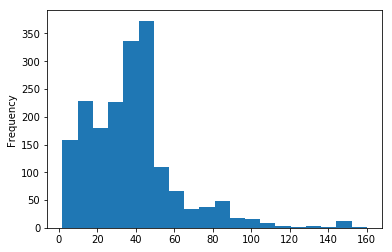

'firebird',


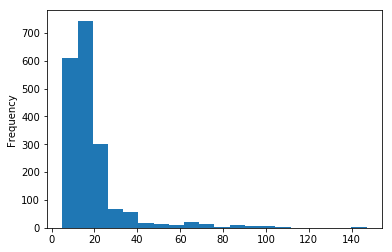

'impala',


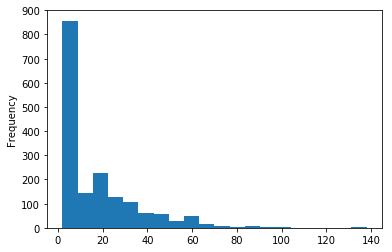

'monetdb',


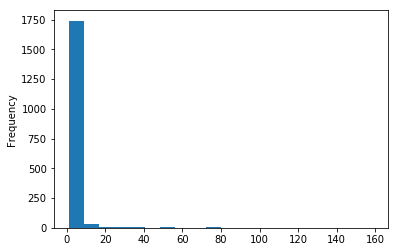

'mssql',


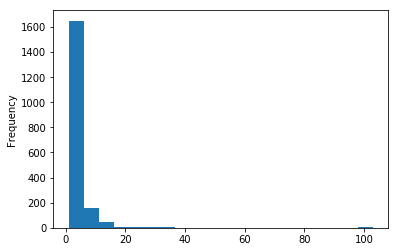

'mysql',


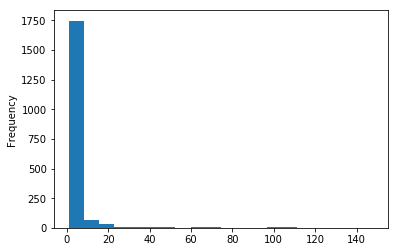

'oracle',


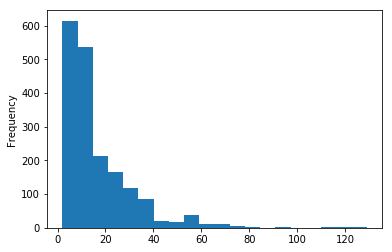

'pgsql',


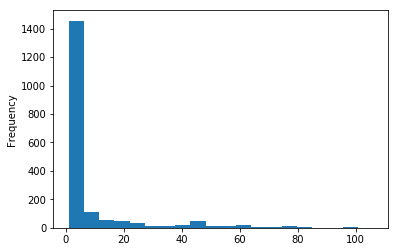

'sqltm',


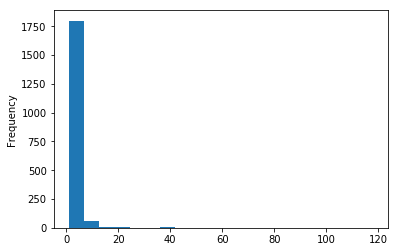

'teradata',


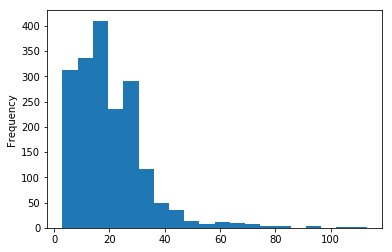

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
